# Chapter 9: Support vector machine (SVM)

### 9.1. Preparation of data
> ###### 9.1.1. Features engineering
> ###### 9.1.2. Standardization

### 9.2. Support vector classifier (SVC)
> ###### 9.2.1. Intuition about how works an SVC
> ###### 9.2.2. Implementation of the model
> ###### 9.2.3. Predictions and backtest

### 9.3. Support vector regressor (SVR)
> ###### 9.3.1. Intuition about how works an SVR
> ###### 9.3.2. Implementation of the model
> ###### 9.3.3. Predictions and backtest

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
plt.style.use('seaborn')
import warnings
warnings.filterwarnings("ignore")
import yfinance as yf
from datetime import datetime
from Backtest import *

### 9.1.1. Features enginneering

In [4]:
# Import EURUSD data
df = yf.download("GOOG",end=datetime.today().strftime('%Y-%m-%d'))[["Adj Close"]].pct_change(1)
df.columns = ["returns"]

# Features engeeniring
df["returns t-1"] = df[["returns"]].shift(1)

# Mean of returns
df["mean returns 15"] = df[["returns"]].rolling(15).mean().shift(1)
df["mean returns 60"] = df[["returns"]].rolling(60).mean().shift(1)

# Volatility of returns
df["volatility returns 15"] = df[["returns"]].rolling(15).std().shift(1)
df["volatility returns 60"] = df[["returns"]].rolling(60).std().shift(1)

# Drop missing values
df = df.dropna()

[*********************100%***********************]  1 of 1 completed


In [5]:
# Percentage train set
split = int(0.80*len(df))

# Train set creation
X_train = df[["returns t-1", "mean returns 15", "mean returns 60",
              "volatility returns 15",
              "volatility returns 60"]].iloc[:split]

y_train_reg = df[["returns"]].iloc[:split]

y_train_cla = np.round(df[["returns"]].iloc[:split]+0.5)


# Test set creation
X_test = df[["returns t-1", "mean returns 15", "mean returns 60",
              "volatility returns 15",
              "volatility returns 60"]].iloc[split:]

y_test_reg = df[["returns"]].iloc[split:]
y_test_cla = np.round(df[["returns"]].iloc[split:]+0.5)

### 9.1.2. Standardization

In [6]:
# Import the class
from sklearn.preprocessing import StandardScaler

# Initialize the class
sc = StandardScaler()

# Standardize the data
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

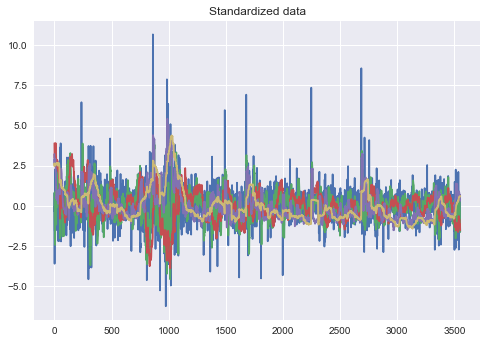

In [7]:
plt.plot(X_train_scaled)
plt.title("Standardized data")
plt.show()

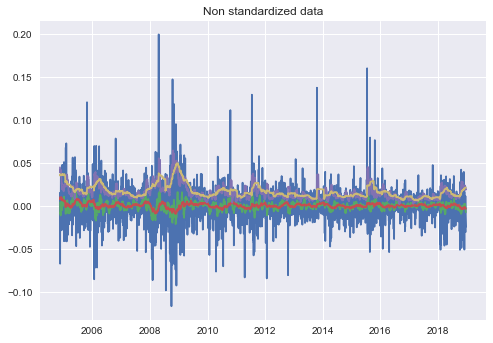

In [8]:
plt.plot(X_train)
plt.title("Non standardized data")
plt.show()

### 9.2.2. Implement an SVC

In [9]:
# Import the class
from sklearn.svm import SVC

# Initialize the class
svc = SVC()

# Fit the model
svc.fit(X_train_scaled, y_train_cla)

SVC()

### 9.2.3. Predictions ans backtest

[*********************100%***********************]  1 of 1 completed

    -----------------------------------------------------------------------------
    Beta: 0.264 	 Alpha: 8.48 %	     Sharpe: 0.417 	 Sortino: 0.508
  -----------------------------------------------------------------------------
    VaR: 59.33 %	 cVaR: 69.85 % 	     VaR/cVaR: 1.177 	 drawdown: 57.28 %
  -----------------------------------------------------------------------------


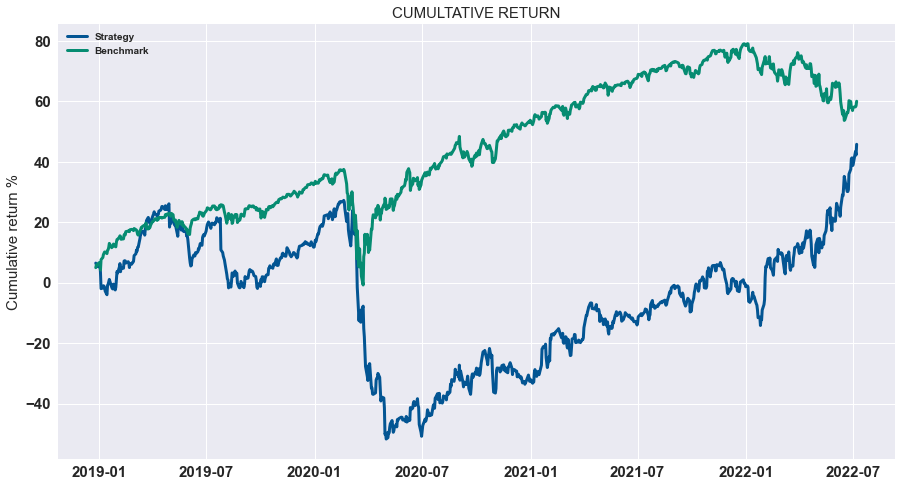

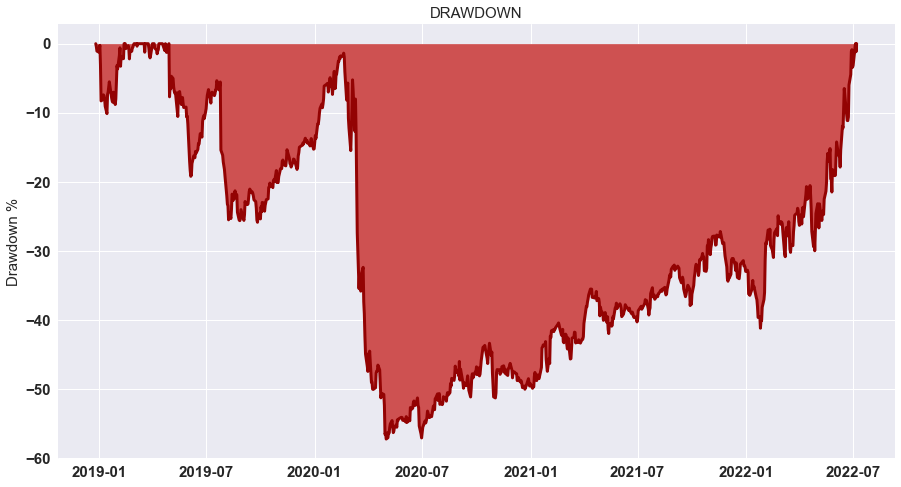

In [10]:
# Create predictions for the whole dataset
df["prediction"] = svc.predict(np.concatenate((X_train_scaled,X_test_scaled),
                                    axis=0))
df["prediction"] = np.where(df["prediction"]==0, -1, 1)

# Compute the strategy
df["strategy"] = df["prediction"] * df["returns"]

# Backtest
backtest_dynamic_portfolio(df["strategy"].iloc[split:])

### 9.3.2. Implement an SVR

In [11]:
# Import the class
from sklearn.svm import SVR

# Initialize the class
lr = SVR()

# Fit the model
lr.fit(X_train_scaled, y_train_reg)

SVR()

### 9.3.3. Predictions and backtest

[*********************100%***********************]  1 of 1 completed

    -----------------------------------------------------------------------------
    Beta: 0.865 	 Alpha: 6.8 %	     Sharpe: 0.692 	 Sortino: 0.921
  -----------------------------------------------------------------------------
    VaR: 51.24 %	 cVaR: 62.47 % 	     VaR/cVaR: 1.219 	 drawdown: 34.2 %
  -----------------------------------------------------------------------------


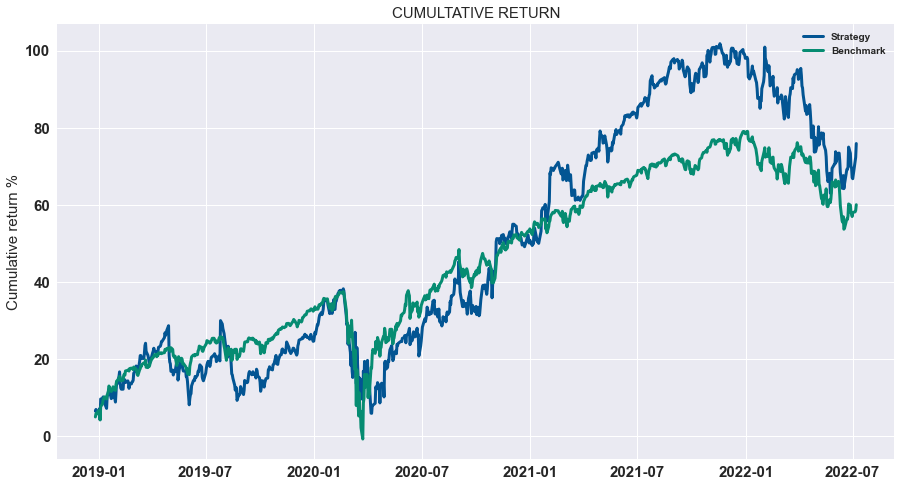

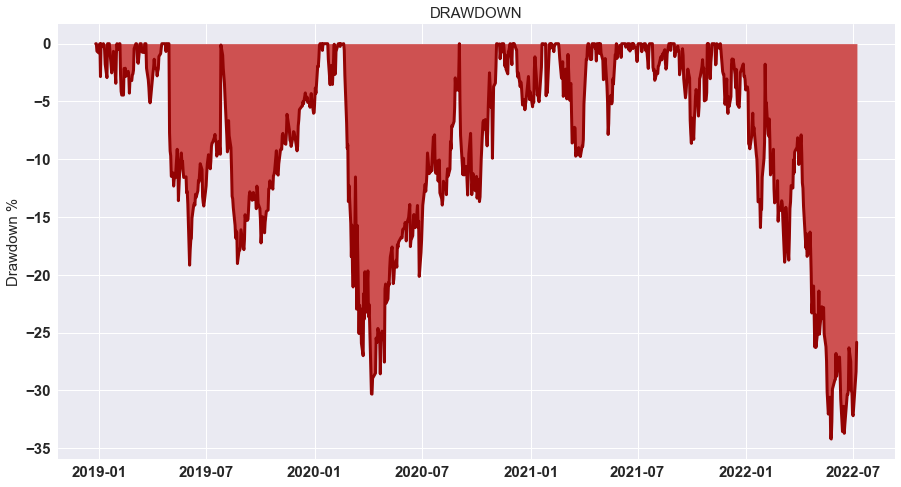

In [12]:
# Create predictions for the whole dataset
df["prediction"] = lr.predict(np.concatenate((X_train_scaled,X_test_scaled),
                                    axis=0))
# Compute the strategy
df["strategy"] = np.sign(df["prediction"]) * df["returns"]

# Backtest
backtest_dynamic_portfolio(df["strategy"].iloc[split:])